In [223]:
rm(list = ls())
pcks <- c('stm', 'dplyr', 'quanteda', 'data.table', 'Hmisc', 'reticulate', 'wordcloud',
          'purrr', 'svMisc', 'data.table', 'lubridate', 'tidyr', 'tictoc', 'stringr')
sapply(pcks, require, character.only = T)

stm      dplyr   quanteda data.table      Hmisc reticulate  wordcloud 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE 
     purrr     svMisc data.table  lubridate      tidyr     tictoc    stringr 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE

In [224]:
out.origin = readRDS('./result/processed.data.for.stm.rds')

### Supporting Packages
>Johannesson. `stmprinter`: Print multiple stm model dashboards to a pdf file for inspection. Beautiful automated reports from multiple stm runs.

>Schwemmer. `stminsights`: A Shiny Application for Inspecting Structural Topic Models. A shiny GUI with beautiful graphics.

>Woloszynek. `themetagenomics`: Exploring Thematic Structure and Predicted Functionality of 16s rRNA Amplicon Data. . STM for rRNA data.

>Johannesson. "`tidystm`: Extract (tidy) effects from estimateEffect" . Makes it easy to make ggplot2 graphics for STM.

>Zangri, Tingley, Stewart. "`stmgui`: Shiny Application for Creating STM Models" . This is a Shiny GUI for running basic STM models.

>Freeman, Chuang, Roberts, Stewart and Tingley. "`stmBrowser`: An R Package for the Structural Topic Model Browser.'' . This D3 visualization allows users to interactively explore the relationships between topics and the covariates estimated from the stm package in R. See an example here .

>Coppola, Roberts, Stewart and Tingley. "`stmCorrViz`: A Tool for Structural Topic Model Visualizations." . This package uses `D3 to generate an interactive hierarchical topic explorer.

### Meta data aggregation

In [225]:
meta.dt <- data.table(out.origin$meta)

colnames(meta.dt)
for (c in colnames(meta.dt)[c(4, 5, 6)]) {
    meta.dt[, .(빈도 = .N), keyby = c] %>% write.csv(., file.path('./metadata', paste(c, '.csv', sep = '')), 
                                                   row.names = F, fileEncoding = 'utf-8')
}

발언자.직함 <- stringr::str_split(meta.dt$`발언자`, ' ') %>% unlist %>% data.table(`발언자.및.직함` = .)
발언자.직함[str_detect(`발언자.및.직함`, '承旼'), `발언자.및.직함` := '유승민']
발언자.직함[str_detect(`발언자.및.직함`, '光琳'), `발언자.및.직함` := '김광림']
발언자.직함[, .N, keyby = `발언자.및.직함`][-1, ] %>% write.csv(., file.path('./metadata', '발언자.및.직함.csv'), row.names = F, fileEncoding = 'utf-8')

[1] "회의록ID"   "대수"       "위원회구분" "위원회"     "회차"      
 [6] "회의일자"   "회의장소"   "발언ID"     "발언순서"   "안건"      
[11] "발언자"     "발언내용"   "token"

> Be careful when converting Chinese characters!

### 1. Preprocessing

options(repr.plot.width=15, repr.plot.height=5)
plotRemoved(out$document, lower.thresh = c(50, 100, 200, 400, 800))

#### 1.1. Referential meta data

In [226]:
r.ch <- fread('./metadata/ref.characters.csv')[`위원회 구분` == '상임위원회',]
pv <- c()
for (p in r.ch$`소속정당`) {
    if (p %in% c('민주통합당', '민주당', '새정치민주연합', '더불어민주당')) {
        pv <- c(pv, '민주당')
    } else {pv <- c(pv, p)}
}
r.ch$`소속정당` <- pv
ref.characters <- r.ch[, .(이름, 소속정당)] %>% unique %>% arrange(이름)

In [227]:
chs = fread('./metadata/발언자.및.직함.csv')
chs[`발언자.및.직함` %in% ref.characters$`이름`,][
    , (total = sum(N))
]

[1] 86420

> included in referential meta data but not in raw data

In [228]:
chs[!str_detect(`발언자.및.직함`, '[가-힣]+'), ]$`발언자.및.직함` %>% sort

[1] "委員"           "委員長"         "委員長代理"     "委員長職務代行"
 [5] "小委員長"       "尹明熙"         "張倫碩"         "徐淸源"        
 [9] "徐相箕"         "成完鍾"         "朱永順"         "朴孟雨"        
[13] "朴成浩"         "李燦烈"         "柳一鎬"         "柳在仲"        
[17] "權垠希"         "河泰慶"         "議員"           "金世淵"        
[21] "金承南"         "金武星"         "金永柱"         "金熙國"        
[25] "金世淵"         "金承南"         "金武星"         "金永柱"        
[29] "金熙國"         "柳一鎬"         "柳在中"         "柳在仲"        
[33] "李完九"         "李宰榮"         "李憲昇"         "李燦烈"

> 한자...

#### 1.2. 메타 데이터에 프레임 씌우기

In [6]:
# For test
samples = sample(1:length(out.origin$documents), 50)

In [7]:
out <- prepDocuments(out.origin$documents[samples], out.origin$vocab, out.origin$meta[samples, ], lower.thresh = 0)

out$meta <- out$meta %>% mutate(회의일자 = as_date(회의일자))
out$meta <- out$meta %>% mutate(시기구분 = factor(ifelse(회의일자 <= date('2014-05-29'), '전반기', '후반기')))
out$meta <- out$meta %>% mutate(회의일자 = as.numeric(회의일자))
out$meta <- out$meta %>% mutate(회의일자 = 회의일자 - min(회의일자) + 1)

out$meta[1, ]

Detected Missing Terms, renumbering 


,회의록ID,대수,위원회구분,위원회,회차,회의일자,회의장소,발언ID,발언순서,안건,발언자,발언내용,token,시기구분
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<list>,<chr>,<chr>,<list>,<fct>
1,42543,19,상임위원회,농림수산식품위원회,제313회(2013.02.04-2013.03.05) - 제3차,240,농림수산식품위원회회의실,980579,191,1. 국무위원후보자(농림수산식품부장관 이동필) 인사청문회,박민수 위원,위원회인가 뭐 하는 것 아시지요?,위원회,전반기


## 2. 모형 적합
### 2.1. 최적모형 찾기

In [8]:
parallel::detectCores()

[1] 8

In [10]:
set.seed(2020)
ntopics = seq(8, 16, 2)

tic(paste(length(ntopics), ' topics:', sep = ''))
국회.19대.stm <- searchK(
    out$documents, out$vocab, data = out$meta,
    K = ntopics, verbose = F
    cores = parallel::detectCores() - 2,
    max.em.its = 50, ngroups = 1,

    prevalence = ~ 시기구분 + s(회의일자),
    content = ~ 시기구분,
)
toc()

Warning message:
“Exclusivity calculation only designed for models without content covariates”


Using multiple-cores.  Progress will not be shown. 
5 topics:: 53.388 sec elapsed


In [11]:
zoscl = function(x) (x - min(x)) / (max(x) - min(x))

require(ggplot2)
scores = as.data.frame(국회.19대.stm$results) %>% unnest(cols = c(K, heldout, residual, bound, lbound, em.its))
scores = scores %>% gather(measure, value, -K)

setDT(scores)
scores[, value := zoscl(value), by = .(measure)]

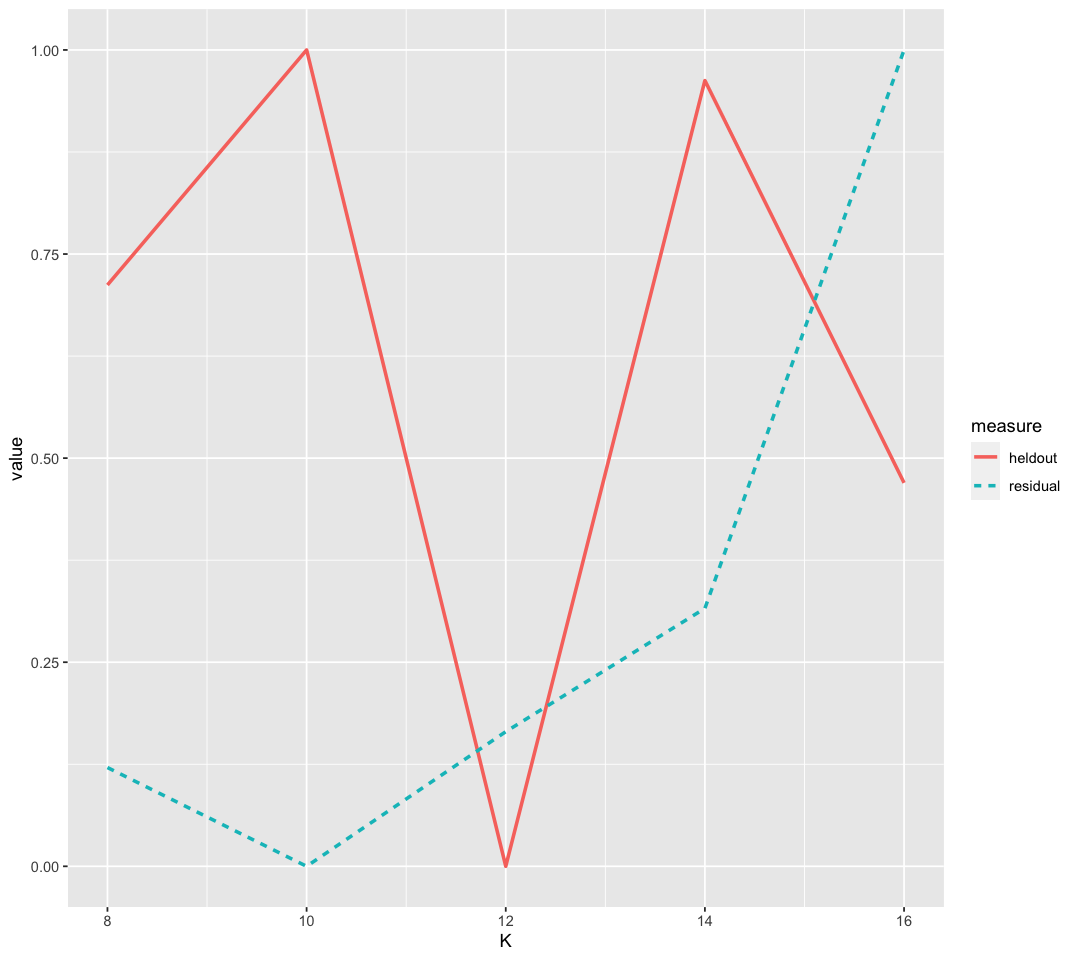

In [12]:
options(repr.plot.width = 9, repr.plot.height = 8)
ggplot(scores[measure %in% c('heldout', 'residual'),], aes(x = K)) +
  geom_line(aes(y = value, lty = measure, col = measure), lwd=1) +
  scale_x_continuous(breaks = ntopics)

### 2.2. 최종 K값 선택

In [13]:
K.opt <- 10
tic('최종모형')
국회.19대.stm.p.c. <- stm(
  out$documents, out$vocab, data = out$meta,
  K = K.opt, verbose = F,
  prevalence = ~ 시기구분 + s(회의일자),
  content = ~ 시기구분,
)
국회.19대.stm.p. <- stm(
  out$documents, out$vocab, data = out$meta,
  K = K.opt, verbose = F,
  prevalence = ~ 시기구분 + s(회의일자),
)
toc()

최종모형: 74.673 sec elapsed


## 3. 모형 시각화

In [16]:
labelTopics(국회.19대.stm.p., 1:3)

Topic 1 Top Words:
 	 Highest Prob: 장관, 답변, 안건, 해석, 실수, 유권, 전환 
 	 FREX: 안건, 해석, 실수, 유권, 전환, 장관, 답변 
 	 Lift: 책임, 이유, 안건, 인권, 진정, 접수, 의결 
 	 Score: 안건, 해석, 유권, 실수, 전환, 장관, 유형 
Topic 2 Top Words:
 	 Highest Prob: 사회, 관련, 후보, 제한, 소송, 기여, 중재 
 	 FREX: 제한, 소송, 기여, 중재, 사명, 참가, 입찰 
 	 Lift: 국회의원, 인사, 청문, 언론, 요청안, 인정, 제한 
 	 Score: 제한, 소송, 참가, 입찰, 담합, 만약, 사명 
Topic 3 Top Words:
 	 Highest Prob: 질의, 능력, 평가, 시스템, 근로, 문제, 추진 
 	 FREX: 질의, 능력, 평가, 시스템, 근로, 개정, 공단 
 	 Lift: 개정, 공단, 시스템, 능력, 평가, 질의, 상황 
 	 Score: 능력, 평가, 질의, 근로, 시스템, 개정, 공단 

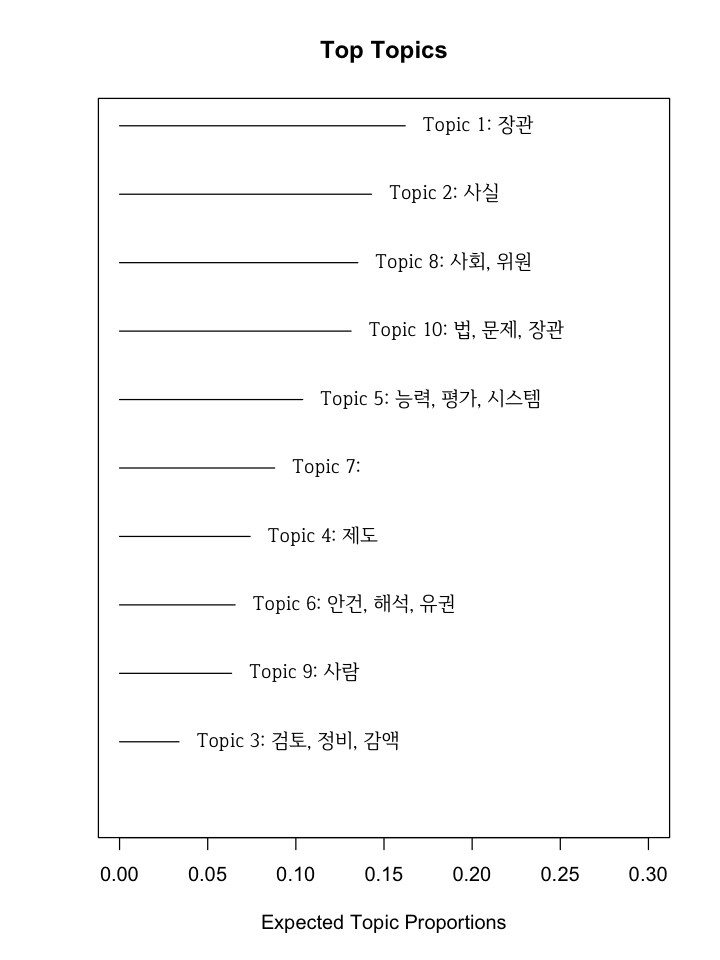

In [20]:
options(repr.plot.width = 6, repr.plot.height = 8)
suppressWarnings({
  plot(국회.19대.stm.p.c., type = 'summary', xlim = c(0, 0.3), family = 'Iropke Batang Medium')
})

In [21]:
form <- paste(paste('1:', K.opt, sep = ''), ' ~ 시기구분', sep = '') %>% formula
prep <- estimateEffect(form, 국회.19대.stm.p.c., meta = out$meta, uncertainty = 'Global')

Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”


In [22]:
set.grph.jl <- function(w, h, f = 'Iropke Batang Medium'){
    options(repr.plot.width = w, repr.plot.height = h)
    par(family = f)
}

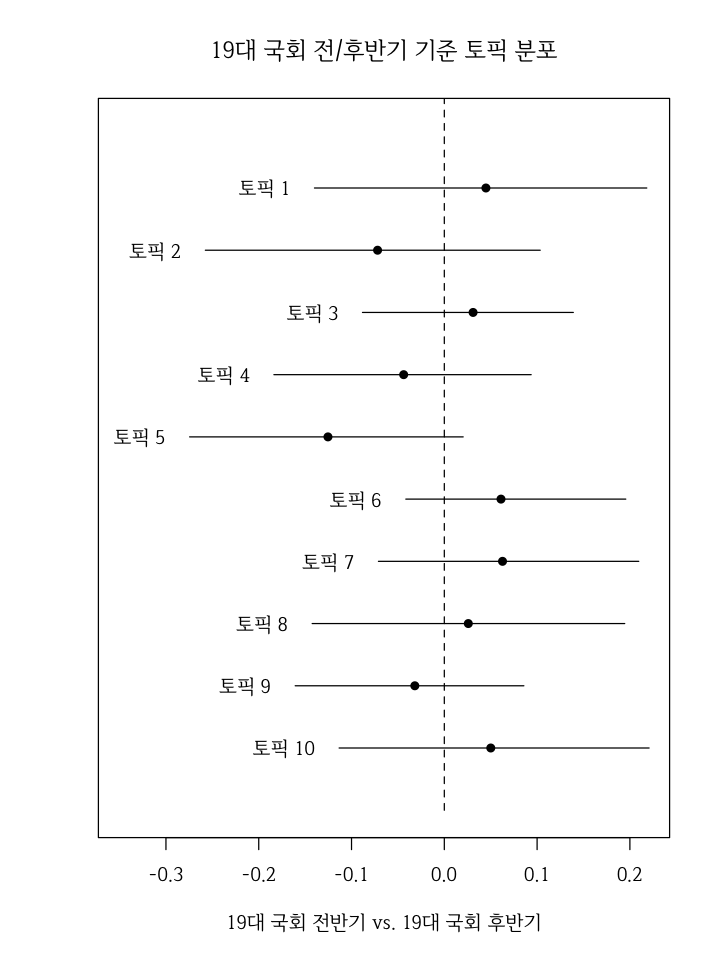

In [33]:
set.grph.jl(6, 8)
suppressWarnings({
  plot(prep, covariate = '시기구분', model = 국회.19대.stm.p.c., method = 'difference',
#        topics = 1:국회.19대.stm$setting$dim$K,
       cov.value1 = '전반기', cov.value2 = '후반기', xlim = c(-.35, .22),
       xlab = '19대 국회 전반기 vs. 19대 국회 후반기', main = '19대 국회 전/후반기 기준 토픽 분포', 
       labeltype = 'custom', custom.labels = paste('토픽', 1:국회.19대.stm.p.c.$setting$dim$K),
       family = 'Iropke Batang Medium'
      )
})

#### Find thoughts

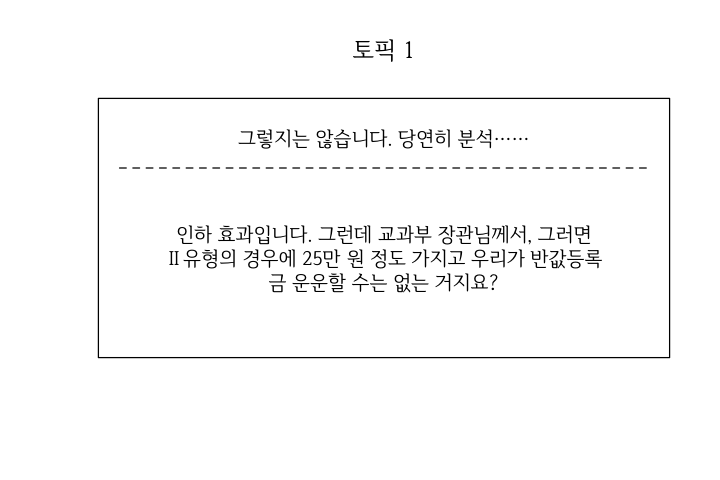

In [35]:
thoughts <- findThoughts(국회.19대.stm.p.c., texts = out$meta$`발언내용`, n = 2, topics = 1)$docs[[1]]

set.grph.jl(6, 4)
suppressWarnings({plotQuote(thoughts, main = '토픽 1', width = 50, family = 'Iropke Batang Medium')})

#### Contrasts

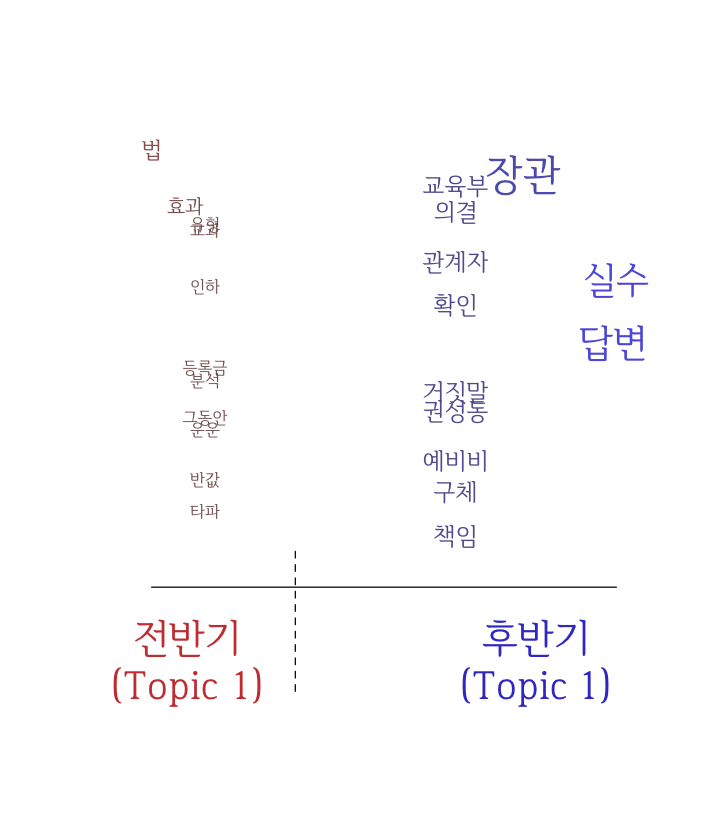

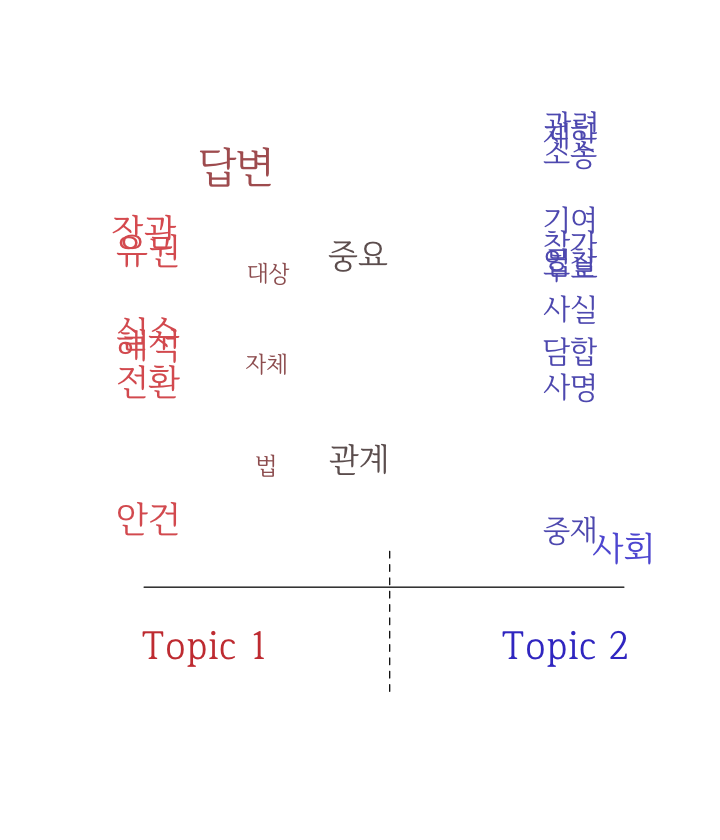

In [46]:
set.grph.jl(6, 7)
suppressWarnings({
    plot(국회.19대.stm.p.c., type = 'perspectives', topics = 1, family = 'Iropke Batang Medium')
    plot(국회.19대.stm.p., type = 'perspectives', topics = 1:2, family = 'Iropke Batang Medium')
})

#### Word Cloud

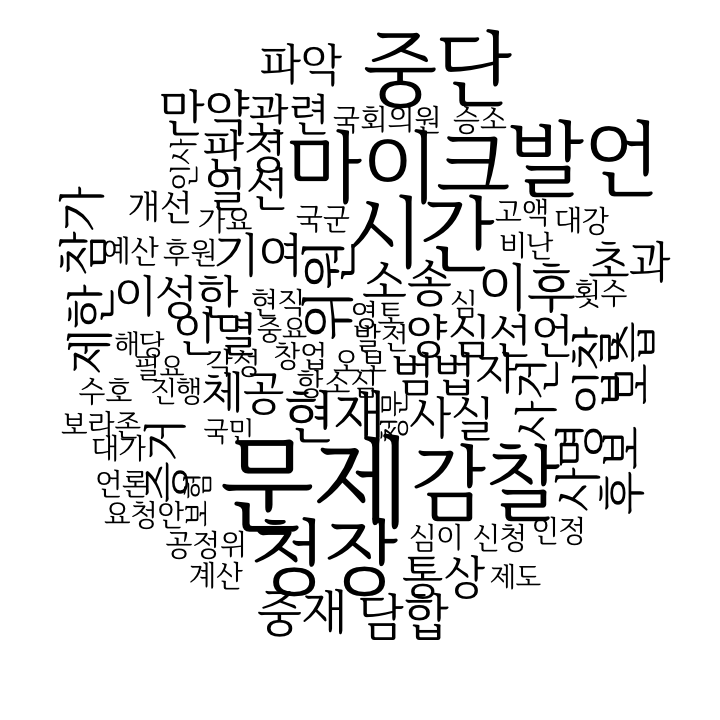

In [56]:
set.grph.jl(6, 6)
suppressWarnings({
    stm::cloud(국회.19대.stm.p.c., topic = 2, scale = c(15, .5), 
               family = 'Iropke Batang Medium')
})

2.378 sec elapsed


Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”


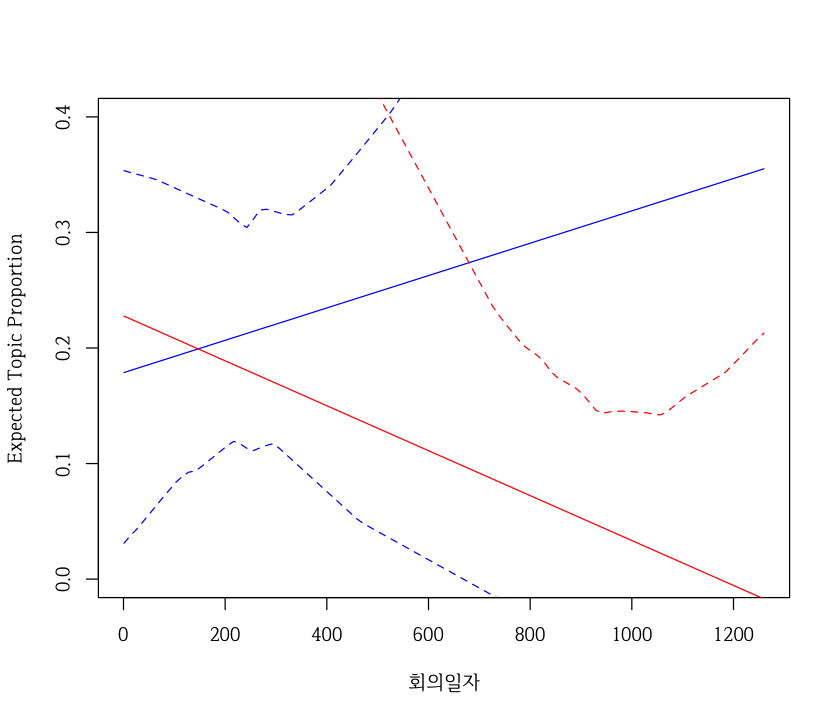

In [85]:
tic()
국회.19대.stm.p.c.i <- stm(
    out$documents, out$vocab, K = K.opt,
    prevalence = ~ 시기구분 * 회의일자, max.em.its = 50, data = out$meta,
    init.type = 'Spectral', verbose = F
)
toc()
prep <- estimateEffect(c(8) ~ 시기구분 * 회의일자, 국회.19대.stm.p.c.i, metadata = out$meta, uncertainty = 'None')

set.grph.jl(7, 6)
suppressWarnings({
    plot(prep, covariate = '회의일자', model = 국회.19대.stm.p.c.i, method = 'continuous', 
         xlab = '회의일자', moderator = '시기구분', moderator.value = '전반기', linecol = 'blue',
         ylim = c(0, .4), printlegend = F)
    plot(prep, covariate = '회의일자', model = 국회.19대.stm.p.c.i, method = 'continuous', 
         xlab = '회의일자', moderator = '시기구분', moderator.value = '후반기', linecol = 'red',
         add = T, printlegend = F)
})

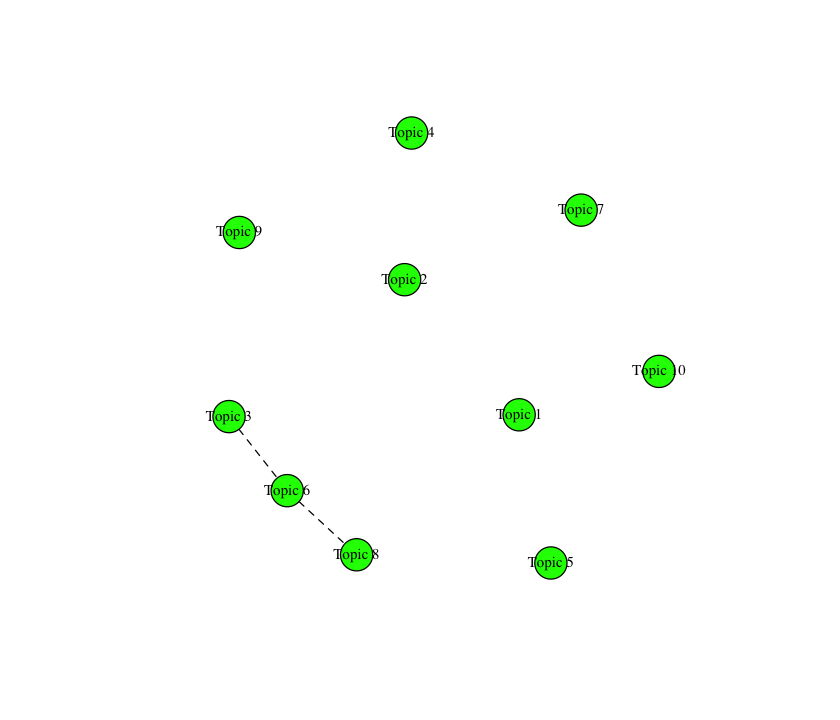

In [96]:
mod.corr <- topicCorr(국회.19대.stm.p.c.)
plot(mod.corr)